In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import warnings 
warnings.filterwarnings('ignore')

from imblearn.combine import SMOTEENN

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_validate

from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn import metrics

from itertools import cycle,product


In [36]:
df=pd.read_csv('latestdata.csv')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131260 entries, 0 to 131259
Data columns (total 34 columns):
ID                          131090 non-null object
age                         5116 non-null object
sex                         5400 non-null object
city                        59680 non-null object
province                    117623 non-null object
country                     131230 non-null object
wuhan(0)_not_wuhan(1)       64744 non-null float64
latitude                    129279 non-null float64
longitude                   129279 non-null float64
geo_resolution              129279 non-null object
date_onset_symptoms         1913 non-null object
date_admission_hospital     961 non-null object
date_confirmation           129877 non-null object
symptoms                    803 non-null object
lives_in_Wuhan              3629 non-null object
travel_history_dates        1163 non-null object
travel_history_location     2636 non-null object
reported_market_exposure    1154 non-nu

In [38]:
df.date_confirmation

0         27.03.2020
1         27.03.2020
2         27.03.2020
3         27.03.2020
4         27.03.2020
             ...    
131255    20.03.2020
131256    20.03.2020
131257    20.03.2020
131258    18.03.2020
131259    26.03.2020
Name: date_confirmation, Length: 131260, dtype: object

In [39]:
df_=df[['country','date_confirmation']].dropna()

In [62]:
df_.groupby('country').count().sort_values('date_confirmation',ascending=False).head()

,date_confirmation
country,
China,30831
United Kingdom,17814
Spain,16157
United States,12477
France,10104


In [79]:
country_list=df_.groupby('country').count().sort_values('date_confirmation',ascending=False).iloc[:10,:].index.to_list()

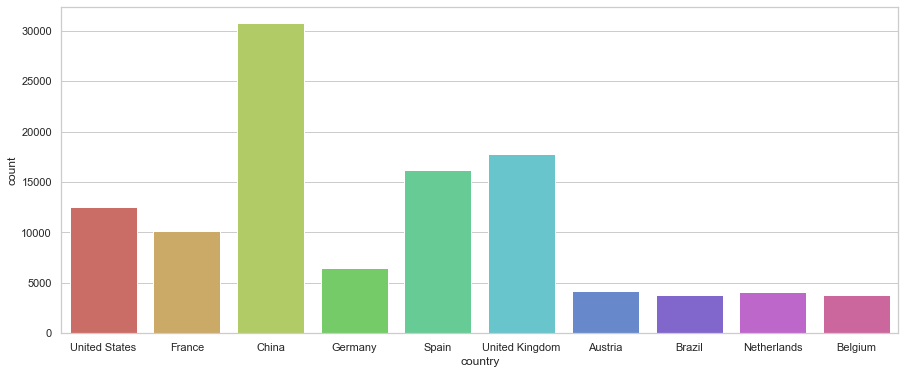

In [84]:
plt.figure(figsize=(15,6))
sns.countplot(x='country',data=df_[df_.country.isin(country_list)], palette='hls')
plt.show()

In [40]:
df_['date_confirmation']=df_.date_confirmation.apply(lambda x:x[3:5]+'.'+x[:2]+'.'+x[6:10])

In [90]:
df_['date_confirmation']=pd.to_datetime(df_.date_confirmation).dt.date

In [91]:
df1=df_.sort_values('date_confirmation')

In [92]:
df1['case']=1

In [93]:
pd.set_option('display.max_rows',500)

df1[['case','date_confirmation']].groupby('date_confirmation').count().reset_index()

,date_confirmation,case
0,2020-01-06,1
1,2020-01-12,1
2,2020-01-15,1
3,2020-01-16,1
4,2020-01-17,1
5,2020-01-18,61
6,2020-01-19,78
7,2020-01-20,12
8,2020-01-21,28
9,2020-01-22,40


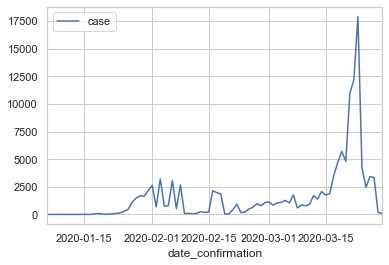

In [95]:
df1.date_confirmation[5]-df1.date_confirmation[0]
df1[['case','date_confirmation']].groupby('date_confirmation').count().plot()

In [134]:
def datapre(df1,co):
    
    df1[df1.country==i][['case','date_confirmation']].groupby('date_confirmation').count().plot(title=co+' daily')
    df=df1[['case','date_confirmation']].groupby('date_confirmation').count().reset_index()
    day1=df.date_confirmation[0]
    df['days']=(df['date_confirmation']-day1).dt.days
    for n in range(1,6):
        df['case-'+str(n)]=df.case.shift(n)
    df['total']=df.case.cumsum()
    df.plot(x='date_confirmation',y='total',title=co+' total')
    return df.dropna()

,date_confirmation,case,days,case-1,case-2,case-3,case-4,case-5,total
5,2020-01-18,61,12,1.0,1.0,1.0,1.0,1.0,66
6,2020-01-19,78,13,61.0,1.0,1.0,1.0,1.0,144
7,2020-01-20,12,14,78.0,61.0,1.0,1.0,1.0,156
8,2020-01-21,28,15,12.0,78.0,61.0,1.0,1.0,184
9,2020-01-22,40,16,28.0,12.0,78.0,61.0,1.0,224
10,2020-01-23,91,17,40.0,28.0,12.0,78.0,61.0,315
11,2020-01-24,134,18,91.0,40.0,28.0,12.0,78.0,449
12,2020-01-25,281,19,134.0,91.0,40.0,28.0,12.0,730
13,2020-01-26,444,20,281.0,134.0,91.0,40.0,28.0,1174
14,2020-01-27,1098,21,444.0,281.0,134.0,91.0,40.0,2272


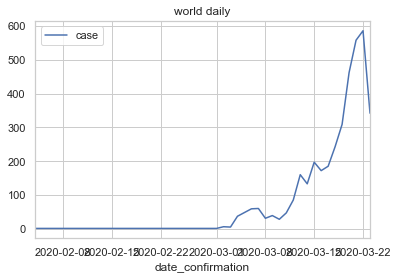

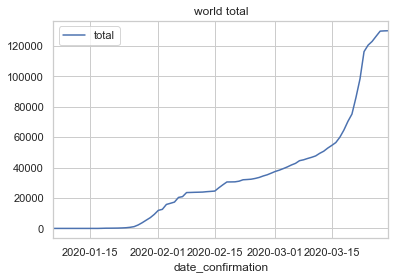

In [135]:
datapre(df1,'world')

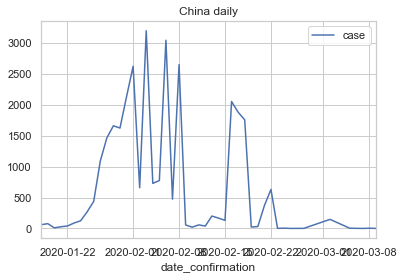

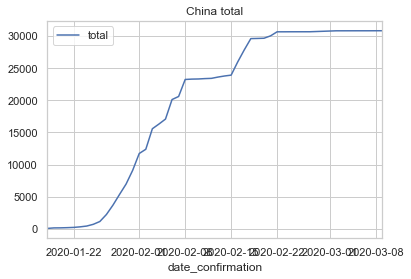

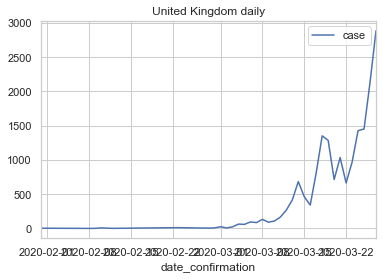

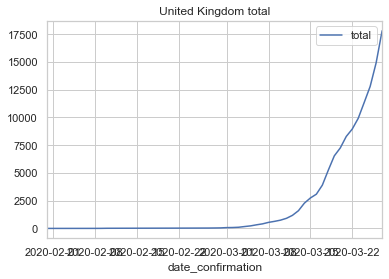

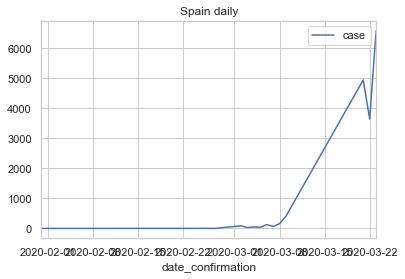

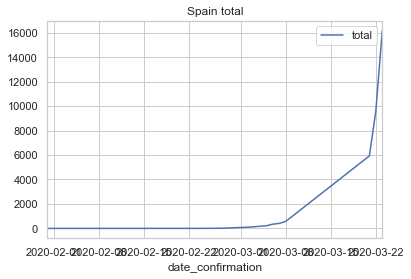

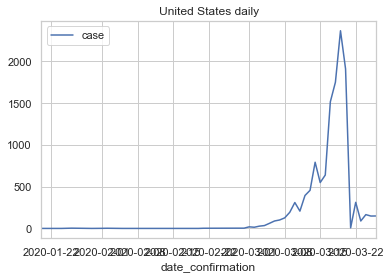

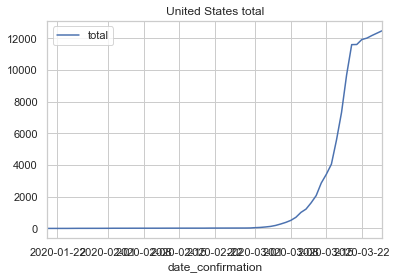

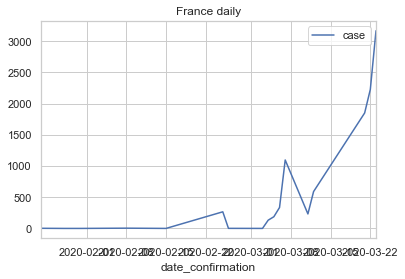

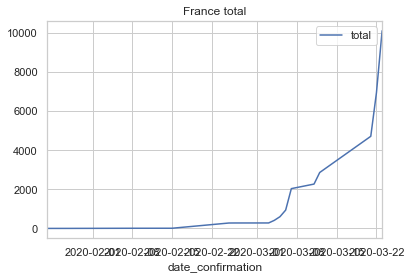

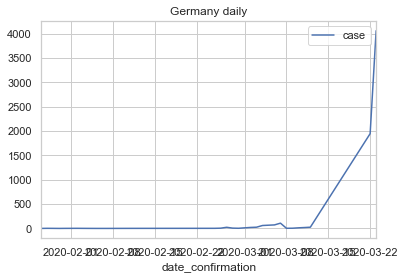

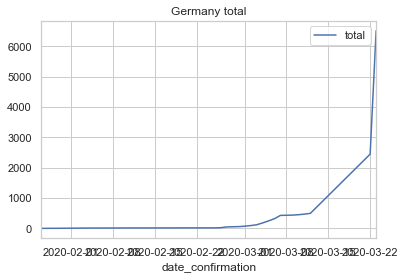

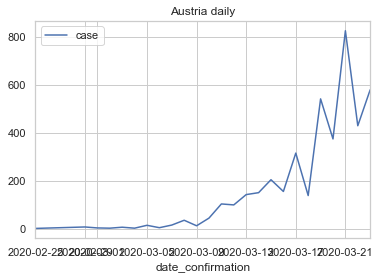

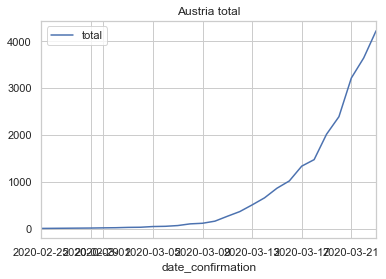

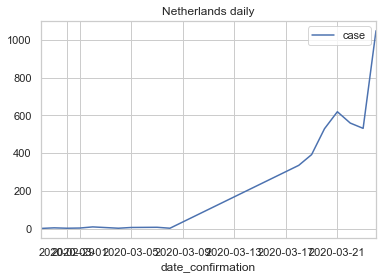

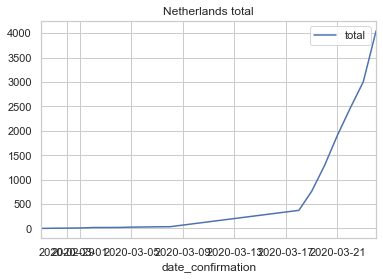

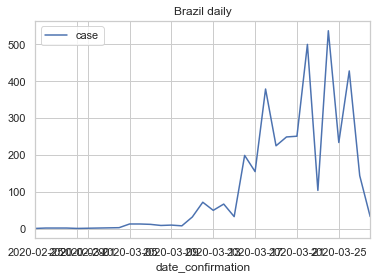

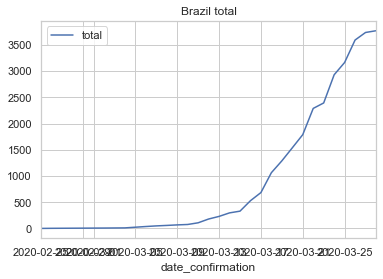

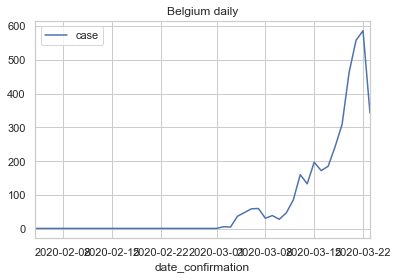

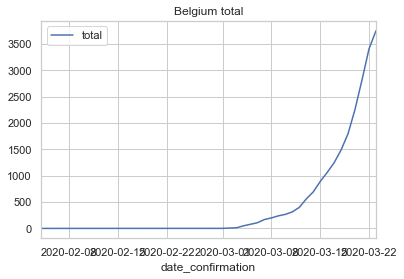

In [136]:
df_all=pd.DataFrame()
for i in country_list:
    
    df_tem=datapre(df1[df1.country==i],i)
    df_tem['country']=i
    df_all=pd.concat([df_all,df_tem])

In [141]:
df_all=pd.concat([df_all.drop(['country','date_confirmation'],axis='columns'), pd.get_dummies(df_all.country)], axis=1)

In [142]:
df_all

,case,days,case-1,case-2,case-3,case-4,case-5,total,Austria,Belgium,Brazil,China,France,Germany,Netherlands,Spain,United Kingdom,United States
5,88,5,40.0,28.0,10.0,78.0,61.0,305,0,0,0,1,0,0,0,0,0,0
6,124,6,88.0,40.0,28.0,10.0,78.0,429,0,0,0,1,0,0,0,0,0,0
7,269,7,124.0,88.0,40.0,28.0,10.0,698,0,0,0,1,0,0,0,0,0,0
8,438,8,269.0,124.0,88.0,40.0,28.0,1136,0,0,0,1,0,0,0,0,0,0
9,1089,9,438.0,269.0,124.0,88.0,40.0,2225,0,0,0,1,0,0,0,0,0,0
10,1464,10,1089.0,438.0,269.0,124.0,88.0,3689,0,0,0,1,0,0,0,0,0,0
11,1660,11,1464.0,1089.0,438.0,269.0,124.0,5349,0,0,0,1,0,0,0,0,0,0
12,1623,12,1660.0,1464.0,1089.0,438.0,269.0,6972,0,0,0,1,0,0,0,0,0,0
13,2130,13,1623.0,1660.0,1464.0,1089.0,438.0,9102,0,0,0,1,0,0,0,0,0,0
14,2621,14,2130.0,1623.0,1660.0,1464.0,1089.0,11723,0,0,0,1,0,0,0,0,0,0


In [195]:
from sklearn.linear_model import LinearRegression as lrg
from sklearn.ensemble import RandomForestRegressor
def lr(df,target,test):
    lrmodel=lrg()

    lrmodel.fit(df.drop(target,axis=1),df[target])

    y_pre=lrmodel.predict(test.drop(target,axis=1))

    regression_results(test[target],y_pre)
    
    
    
    plt.figure(figsize=(15,6))
    plt.plot(y_pre,label='pre')
    plt.plot(test.reset_index()[target],label='true')
    plt.legend()

    return lrmodel

def rf(df,target,test):
    model=RandomForestRegressor()

    model.fit(df.drop(target,axis=1),df[target])

    y_pre=model.predict(test.drop(target,axis=1))

    regression_results(test[target],y_pre)

    
    plt.figure(figsize=(15,6))
    plt.plot(y_pre,label='pre')
    plt.plot(test.reset_index()[target],label='true')
    plt.legend()

    return model

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [199]:
df_train, df_test  = train_test_split(df_all,test_size=0.3)

explained_variance:  0.7112
r2:  0.7054
MAE:  207.0418
MSE:  177860.1039
RMSE:  421.7346


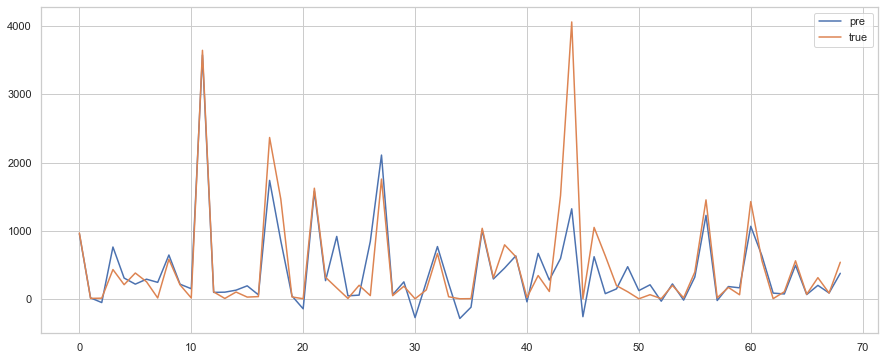

In [200]:
lr1=lr(df_train,'case',df_test)

explained_variance:  0.7753
r2:  0.7749
MAE:  180.2814
MSE:  135869.1704
RMSE:  368.6044


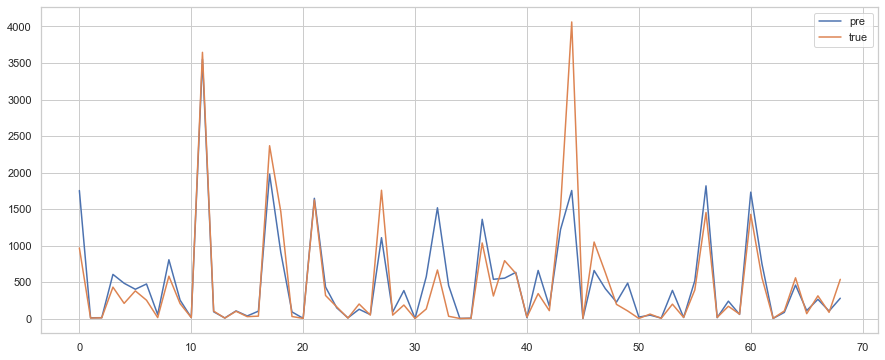

In [201]:
rf1=rf(df_train,'case',df_test)